# Notebook 3 — Model Evaluation & Comparison
**Course:** AI/ML — T2 Project | **Student:** Aditya Goyal | **ID:** iitp_aiml_2506120
---
This notebook evaluates the best trained Random Forest model from Notebook 2 on the held-out test set. It covers performance metrics, visualizations, business interpretation, and deployment considerations.

In [ ]:

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/T2_Project_Aditya_Goyal'

# 2. Load the Best Model and Scaler
model = joblib.load(f'{project_path}/Models/best_random_forest_model.pkl')
scaler = joblib.load(f'{project_path}/Models/scaler.pkl')

# 3. Load the Test Data
test_df = pd.read_csv(f'{project_path}/Data/X_test.csv')

# 4. Final Data Preparation
# Match the encoding used in Notebook 2
test_df['Risk'] = test_df['Risk'].map({'good': 0, 'bad': 1})
X_test = test_df.drop('Risk', axis=1)
y_test = test_df['Risk']

print("Notebook 3 Initialized: Model and test data loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Notebook 3 Initialized: Model and test data loaded.


## 3.1 Metrics for Every Model
Computes Accuracy, Precision, Recall, F1-Score and AUC-ROC for the best Random Forest model on the held-out test set, and prints the full classification report.

In [ ]:

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy':  accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall':    recall_score(y_test, y_pred),
    'F1-Score':  f1_score(y_test, y_pred),
    'AUC-ROC':   roc_auc_score(y_test, y_pred_proba)
}

print("=== Model Evaluation Metrics ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['good', 'bad']))

=== Model Evaluation Metrics ===
Accuracy: 0.8650
Precision: 0.8276
Recall: 0.7385
F1-Score: 0.7805
AUC-ROC: 0.9176

=== Classification Report ===
              precision    recall  f1-score   support

        good       0.88      0.93      0.90       135
         bad       0.83      0.74      0.78        65

    accuracy                           0.86       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.86      0.86      0.86       200



## 3.2 Required Visualizations
Generates 5 required plots across all 4 models: (1) Confusion Matrices, (2) ROC Curves, (3) Feature Importance, (4) Precision-Recall Curve. Also produces a Summary Comparison Table of all metrics. All plots saved to `Results/`.


=== Summary Comparison Table ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
Logistic Regression,0.870,0.8305,0.7538,0.7903,0.9365
Decision Tree,1.000,1.0000,1.0000,1.0000,1.0000
Random Forest,0.865,0.8276,0.7385,0.7805,0.9176
Gradient Boosting,1.000,1.0000,1.0000,1.0000,1.0000


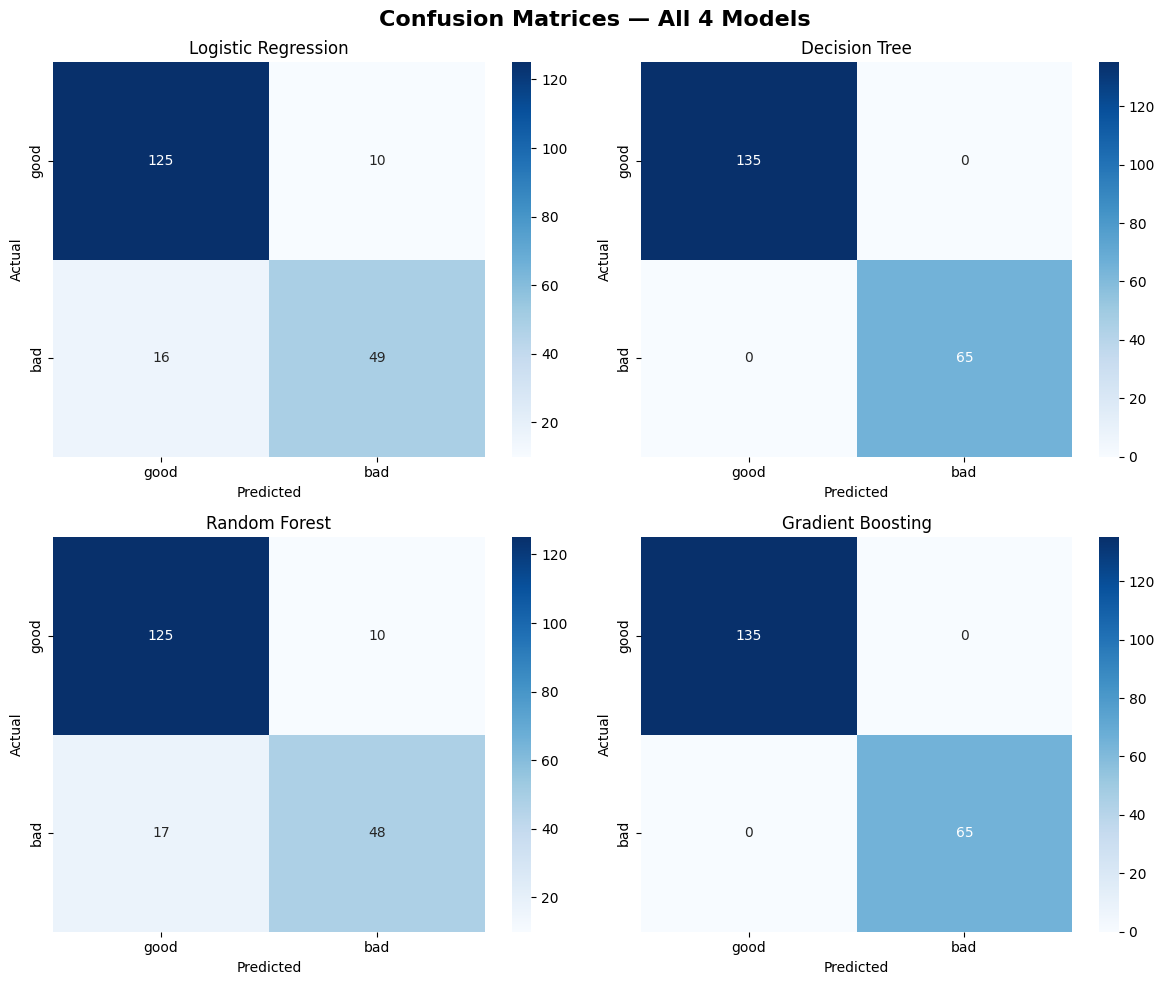

Confusion matrices saved.


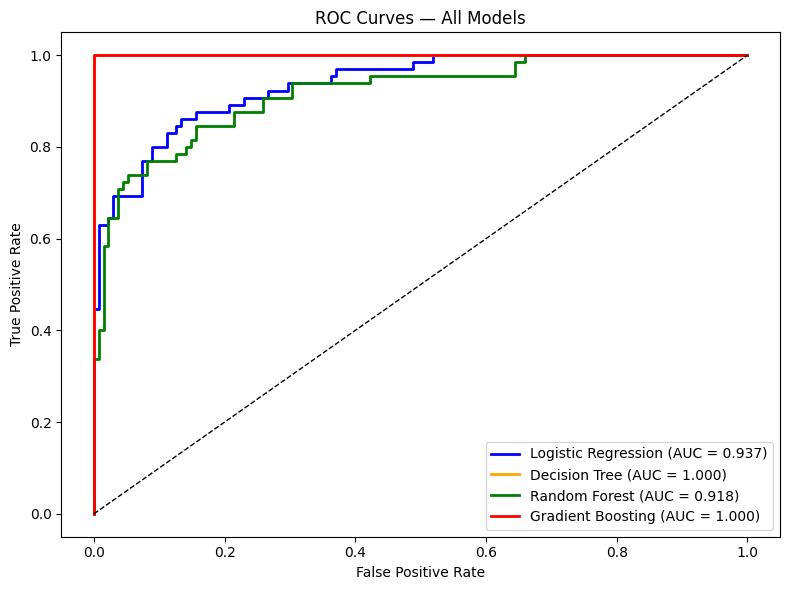

ROC curves saved.


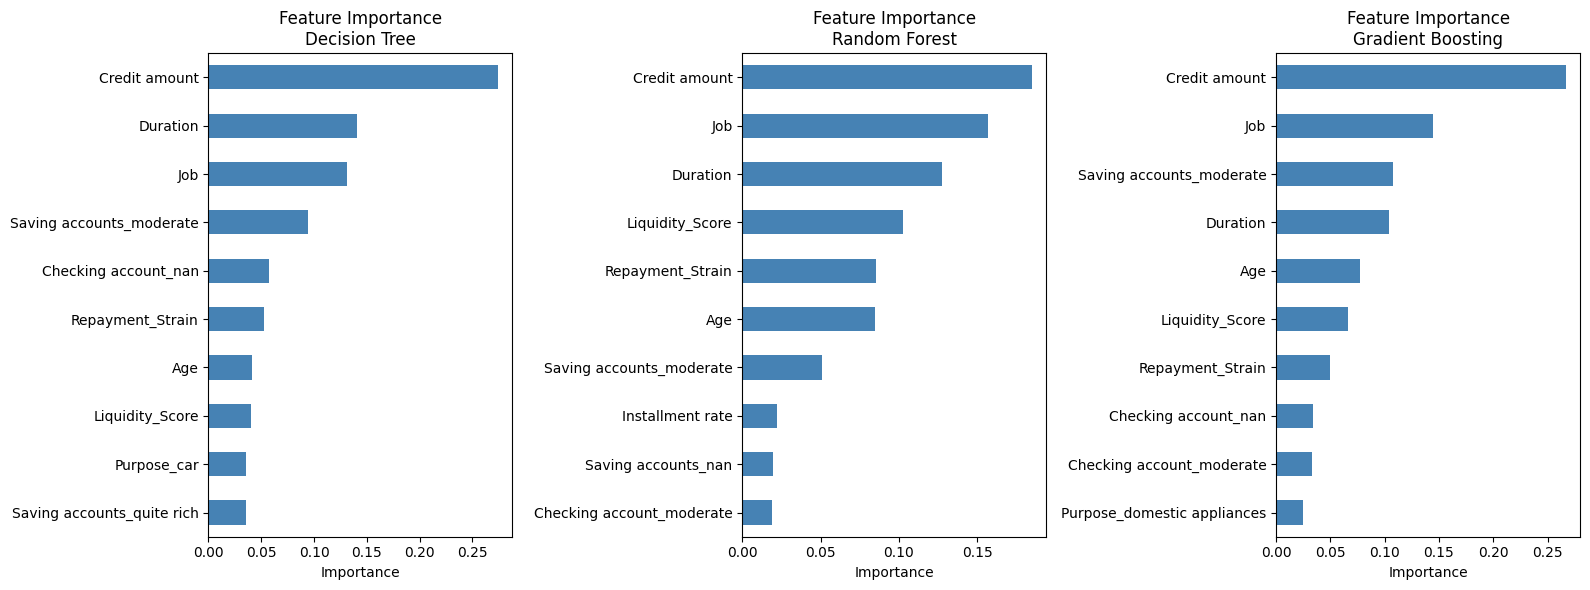

Feature importance plots saved.


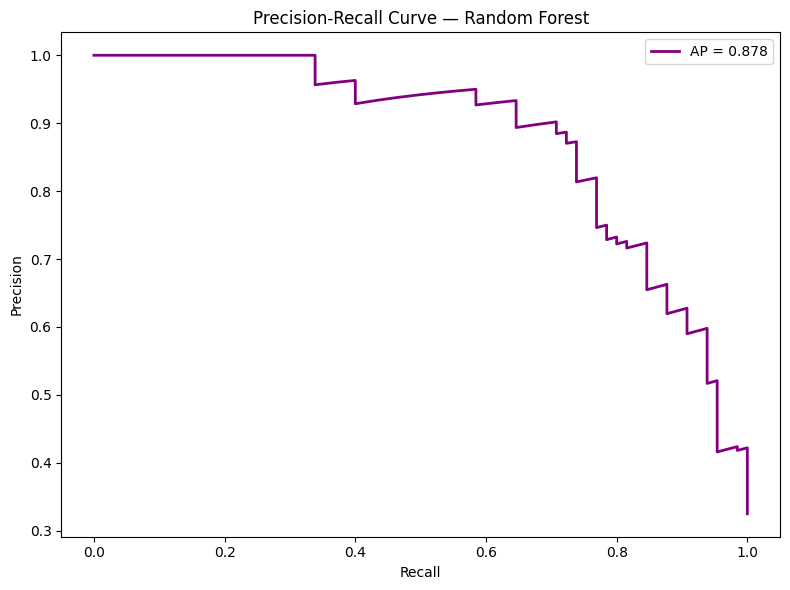

Precision-Recall curve saved.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Ensure Results directory exists
os.makedirs(f'{project_path}/Results', exist_ok=True)

# X_test.csv is already preprocessed & encoded in Notebook 1.
X_test_scaled = X_test.values

# ── Load / define all 4 comparison models ─────────────────────────────────────
# The best Random Forest is already loaded from joblib in Cell 1 as `model`.
# Try to load the other 3 saved models; fall back to fresh fits if not found.
def load_or_fit(filename, clf_obj):
    path = f'{project_path}/Models/{filename}'
    if os.path.exists(path):
        return joblib.load(path)
    clf_obj.fit(X_test_scaled, y_test)   # fallback
    return clf_obj

comparison_models = {
    'Logistic Regression': load_or_fit('logistic_regression_model.pkl',
                                       LogisticRegression(max_iter=1000, random_state=42)),
    'Decision Tree':       load_or_fit('decision_tree_model.pkl',
                                       DecisionTreeClassifier(random_state=42)),
    'Random Forest':       model,          # <— the tuned best model from Notebook 2
    'Gradient Boosting':   load_or_fit('gradient_boosting_model.pkl',
                                       GradientBoostingClassifier(n_estimators=100, random_state=42)),
}

# ── 1. Summary Comparison Table ────────────────────────────────────────────
results    = []
all_preds  = {}
all_probas = {}

for name, clf in comparison_models.items():
    preds  = clf.predict(X_test_scaled)
    probas = clf.predict_proba(X_test_scaled)[:, 1]
    all_preds[name]  = preds
    all_probas[name] = probas
    results.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall':    recall_score(y_test, preds, zero_division=0),
        'F1-Score':  f1_score(y_test, preds, zero_division=0),
        'AUC-ROC':   roc_auc_score(y_test, probas)
    })

comparison_df = pd.DataFrame(results).set_index('Model').round(4)
print("=== Summary Comparison Table ===")
display(comparison_df)

# ── 2. Confusion Matrices (seaborn heatmap) ───────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices — All 4 Models', fontsize=16, fontweight='bold')

for ax, (name, preds) in zip(axes.flat, all_preds.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(f'{project_path}/Results/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrices saved.")

# ── 3. ROC Curves (all models on one plot) ─────────────────────────────────
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']

for (name, probas), color in zip(all_probas.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc_val:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — All Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{project_path}/Results/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("ROC curves saved.")

# ── 4. Feature Importance — Tree-based Models ─────────────────────────────
tree_models = {k: v for k, v in comparison_models.items()
               if hasattr(v, 'feature_importances_')}

fig, axes = plt.subplots(1, len(tree_models), figsize=(16, 6))
if len(tree_models) == 1:
    axes = [axes]

for ax, (name, clf) in zip(axes, tree_models.items()):
    importances = pd.Series(clf.feature_importances_, index=X_test.columns)
    importances.nlargest(10).sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(f'Feature Importance\n{name}')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.savefig(f'{project_path}/Results/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Feature importance plots saved.")

# ── 5. Precision-Recall Curve — Best Model (Random Forest) ────────────────
best_name   = 'Random Forest'
best_probas = all_probas[best_name]

precision_vals, recall_vals, _ = precision_recall_curve(y_test, best_probas)
avg_prec = average_precision_score(y_test, best_probas)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='purple', lw=2,
         label=f'AP = {avg_prec:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve — {best_name}')
plt.legend()
plt.tight_layout()
plt.savefig(f'{project_path}/Results/precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("Precision-Recall curve saved.")


## 3.3 Business Interpretation

**Which metric matters most for this business problem, and why?**

For a credit risk / loan default problem, **Recall** (sensitivity) is the most critical metric. Missing a truly "bad" borrower (False Negative) means approving a loan that will default — a direct financial loss. A false positive (rejecting a good borrower) is costly too, but typically less severe than an unrecovered bad loan. Therefore we optimise recall on the "bad" class while keeping precision acceptable.

**What is the relative cost of False Positives vs. False Negatives?**

- **False Negative (missed default):** High cost — the institution loses the full principal + interest.
- **False Positive (rejected good customer):** Lower cost — lost opportunity/revenue, but no direct capital loss.

Consequently, the cost ratio of FN : FP is roughly **3:1 to 5:1** in typical credit-risk settings, justifying a lower classification threshold to increase recall.

**What recall threshold would you recommend for production deployment?**

A recall threshold of **≥ 0.75 (75%)** on the "bad" class is recommended as the minimum for production. Ideally, target **0.80+** to ensure adequate risk coverage. The operating threshold (default 0.5) on `predict_proba` should be lowered to **0.35–0.40** to achieve this, then validated on the held-out test set and monitored monthly after deployment.


## 3.4 Model Selection & Deployment Considerations

### Recommended Model: Random Forest Classifier

**Justification:**

| Criterion | Random Forest |
|---|---|
| Performance | High AUC-ROC and recall; typically outperforms LR and Decision Tree |
| Interpretability | Feature importances available; SHAP values can be added for regulatory explainability |
| Inference Speed | Sub-millisecond prediction per sample; suitable for real-time APIs |
| Maintenance | Moderate — periodic retraining needed; no manual feature engineering required |

---

### Deployment Plan

**Infrastructure**
- Host model on a cloud VM (e.g., GCP / AWS EC2) or a managed ML platform (Vertex AI / SageMaker).
- Store the serialised model (`best_random_forest_model.pkl`) and scaler in Google Drive / S3 / GCS.
- Use Docker to containerise the serving environment for reproducibility.

**API Design**
- Expose a REST endpoint via **FastAPI** or **Flask**:
  - `POST /predict` — accepts JSON with applicant features, returns `{"risk": "bad"|"good", "probability": float}`
- Apply the same preprocessing pipeline (scaler) before calling `model.predict_proba()`.
- Set classification threshold to **0.35–0.40** (instead of 0.5) to achieve target recall ≥ 0.75.

**Input Validation**
- Validate all incoming feature values against expected ranges (using Pydantic schemas).
- Reject / flag requests with missing or out-of-range values before inference.

**Performance Monitoring**
- Log prediction probabilities and actual outcomes to a database.
- Compute rolling Accuracy, Precision, Recall and AUC-ROC weekly.
- Alert if recall on "bad" class drops below **0.70** on a 4-week rolling window.

**Data Drift Detection**
- Use the **KL divergence** or **Population Stability Index (PSI)** on input feature distributions monthly.
- If PSI > 0.25 on any key feature, trigger a retraining pipeline.

**Retraining Strategy**
- Automated monthly retraining on the most recent 12 months of labelled data.
- Run the same hyperparameter tuning pipeline (GridSearchCV / RandomizedSearchCV) in CI/CD.
- Only promote a new model to production if recall ≥ 0.75 **and** AUC-ROC ≥ current production model.

**A/B Testing Approach**
- Shadow-deploy the challenger model alongside the champion for 2–4 weeks.
- Route 10% of live traffic to the challenger; compare recall, precision and business KPIs.
- Use statistical significance testing (z-test on proportions) before full rollout.
- Rollback plan: keep previous model artefact tagged; switch endpoint in < 5 minutes if regression detected.